# Discrete Event Game Simulation

The objective is to simulate a discrete-event two-player game in which players take turns rolling dice and performing an consequential action. The rules are as follows:

There are two players, A and B. At the beginning of the game, each starts with 4 coins, and there are 2 coins in the pot. A goes first, then B, then A,. . . . During a particular player’s turn, the player tosses a 6-sided die. If the player rolls a:

    • 1, then the player does nothing.
    • 2: then the player takes all coins in the pot.
    • 3: then the player takes half of the coins in the pot (rounded down).
    • 4,5,6: then the player puts a coin in the pot.
    
A player loses (and the game is over) if they are unable to perform the task (i.e., if they have 0 coins and need to place one in the pot). We define a cycle as A and then B completing their turns. The exception is if a player goes out; that is the
final cycle (but it still counts as the last cycle).

The rules of this game are deterministic and there is no decision-making element to the game, thus, it is easily simulated using a pseudo-random number generator and variables that store the defining attributes of the game. The foundation of the simulation is the ‘random.uniform’ function from the ‘random’ package in Python. Random samples are taken from a Unif[0, 1] distribution and are inverted to simulate a dice-roll using the Inverse Transform Theorem. The game is simulated 100,000 times and the cycle length of each game is recorded and stored for analysis. The experiment uncovered that the distribution of cycle length resembles a distribution as follows: Y ~ 4 + Geom(0.057). I then implement and perform a chi-squared goodness of fit test for cycle length with this distribution.

In [53]:
import random
import math
from matplotlib import pyplot as plt
import numpy as np
import statistics
from scipy.stats import geom
from scipy.stats import chi2
from collections import defaultdict

In [2]:
# Dice-roll PRN Generator Test

print(math.ceil(6*random.uniform(0,1)))

6


In [56]:
# Function that runs 1 instance of the game. 
# Print statements that detail the roll and outcome of each turn are commented out.
# Function returns the total number of cycles

def game():
    playerA_coins = 4
    playerB_coins = 4
    pot_coins = 2
    turn_number = 0
    a = 1
    while(a == 1):
        turn_number += 1
#         print('Turn Number: ' + str(turn_number))
        roll = math.ceil(6 * random.uniform(0, 1))
        if turn_number % 2 == 1:
            if roll == 2:
#                 print('Player A rolled a ' + str(roll) + '.')
                playerA_coins += pot_coins
                pot_coins = 0
            elif roll == 3:
#                 print('Player A rolled a ' + str(roll) + '.')
                t = math.floor(0.5 * pot_coins)
                playerA_coins += t
                pot_coins -= t
            elif roll >= 4:
#                 print('Player A rolled a ' + str(roll) + '.')
                if playerA_coins == 0:
#                     print('The game has ended. Player B wins!')
#                     print('Total cycles: ' + str(math.ceil(turn_number/2)))
                    break
                else:
                    playerA_coins -= 1
                    pot_coins += 1
            else:
                pass
#                 print('Player A rolled a ' + str(roll) + '.')
        if turn_number % 2 == 0:
            if roll == 2:
#                 print('Player B rolled a ' + str(roll) + '.')
                playerB_coins += pot_coins
                pot_coins = 0
            elif roll == 3:
#                 print('Player B rolled a ' + str(roll) + '.')
                t = math.floor(0.5 * pot_coins)
                playerB_coins += t
                pot_coins -= t
            elif roll >= 4:
#                 print('Player B rolled a ' + str(roll) + '.')
                if playerB_coins == 0:
#                     print('The game has ended. Player A wins!')
#                     print('Total cycles: ' + str(math.ceil(turn_number/2)))
                    break
                else:
                    playerB_coins -= 1
                    pot_coins += 1
            else:
                pass
#                 print('Player B rolled a ' + str(roll) + '.')
#         print('Player A has ' + str(playerA_coins) + ' coins.')
#         print('Player B has ' + str(playerB_coins) + ' coins.')
#         print('There are ' + str(pot_coins) + ' coins in the pot.')
#         print()
    return math.ceil(turn_number/2)

In [57]:
game()

30

In [58]:
# Code block runs the Game Function 100,000 times and outputs the cycle length of each run into a list

x = [game() for i in range(100000)]
print(len(x))
print(min(x))
print(max(x))
print(statistics.mean(x))

100000
5
175
17.48788


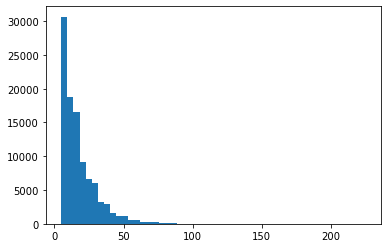

In [15]:
## Histogram of output from 100,000 runs

plt.hist(x, bins = 50)

plt.show()

Estimate for p-hat: 0.05695980460508629


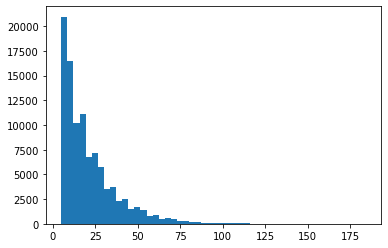

In [16]:
## Estimate p-hat as 1/x-bar (MLE for Geometric Distribution)
## Histogram of 100,000 [4 + geom(p_hat)] random variables

p_hat = 1/(statistics.mean(x))
print('Estimate for p-hat: ' + str(p_hat))

y = [4 + np.random.geometric(p=p_hat) for i in range(100000)]
plt.hist(y, bins = 50)
plt.show()

In [59]:
## Chi-squared G.O.F. Test

geom.pmf(5, p_hat, loc=4)

## Compute probabilities from 4 + geom(5, p_hat)
## Cut off right tail at x = 80, all probabilities for x = 80+ placed into bucket

probabilities = {i:geom.pmf(i, p_hat, loc=4) for i in range(5, 81)}
probabilities[80] = 1 - geom.cdf(79, p_hat, loc=4)

E_Y = {k:100000*v for k, v in probabilities.items()}

O_Y = defaultdict(int)
for item in x:
    O_Y[item] += 1

sort = list(O_Y.keys())
sort.sort()
O_Y_sort = {i: O_Y[i] for i in sort}

## Construct x = 80+ bin for observed values

o_bucket = 0
for k, v in O_Y_sort.items():
    if k >= 80:
        o_bucket += v
O_Y_sort[80] = o_bucket
O_Y_final = {k:v for k, v in O_Y_sort.items() if k <=80}


## Match Expected and Observed values in a default dictionary

dd = defaultdict(list)
for d in (E_Y, O_Y_final): 
    for key, value in d.items():
        dd[key].append(value)

dd_match = {k:v for k, v in dd.items() if len(v) == 2}

## Compute chi-squared test statistic

list_of_lists = [v for k, v in dd_match.items()]
test_stats = [((tup[0] - tup[1])**2)/tup[0] for tup in list_of_lists]
chi_sq = sum(test_stats)

print(chi_sq)
print('Degrees of Freedom: ' + str(len(test_stats) - 1 - 1))
print('Chi-squared test statistic with 0.05 p-value from table: ' + str(109.074))
print(chi2.cdf(chi_sq, df = 74))

6189.967642755946
Degrees of Freedom: 74
Chi-squared test statistic with 0.05 p-value from table: 109.074
1.0


The chi-squared test statistic is 6190, significatly higher than the statistic required to reject the null hypothesis that the distribution of cycle length does not resemble a 4 + geom(0.057) distribution. However, if the expected and observed values are placed into buckets(e.g. 5-10, 10-15,...) before performing the chi-squared test, the error would improve substantially, and the result could possibly indicate that the geometric distribution is a good fit.